In [1]:
import pandas as pd
import yaml
import sqlite3

customer_statistics = '/content/sample_data/customer_statistics.csv'
orders = '/content/sample_data/orders.csv'
customer_demographics = '/content/sample_data/customer_demographics.yaml'


with open(customer_demographics, 'r') as file:
    data = yaml.safe_load(file)

df_customer_demographics = pd.DataFrame(data).transpose()
df_customer_statistics = pd.read_csv(customer_statistics)
df_orders = pd.read_csv(orders)


In [2]:
df_customer_demographics

,address,city,credit_card_expires,credit_card_number,credit_card_provider,credit_card_security_code,customer_id,email,name,phone_number,state,zip_code
0,621 Chavez Ramp Suite 938,West Deniseport,06/31,2269172571677458,Diners Club / Carte Blanche,338,a8c966a0-b670-4044-826c-0e6bfe708259,brett00@example.com,Ronald Rodgers,None,New York,59237
1,592 Mccoy River,Port Dannymouth,11/24,676320507830,JCB 16 digit,246,56b850e0-9320-4aa0-8cd4-d1199903c90e,smithjennifer@example.net,Mary Mitchell,None,Montana,17401
2,8923 Aaron Turnpike,Port Rhondaton,11/31,4607779976715144588,JCB 16 digit,869,5ec9f613-adb1-4e69-8a1a-9530cb777886,twhite@example.net,Nathan Wells,+1-893-568-2182x593,North Dakota,07166
3,496 Margaret Shoals,Smithborough,04/33,4234465830748237,Mastercard,497,ca182662-b281-433a-a82b-8e061f7bf2cd,nguyenjennifer@example.com,Kelly Ramos,820-824-2003,Iowa,42755
4,0807 Logan Fords Suite 355,Contrerasside,10/25,4985681645741,Discover,927,1e7c3a60-4788-4711-809f-b6f8bfbdb18a,michaelabarr@example.net,Rebekah Fitzgerald,+1-269-384-1623x34240,Connecticut,64282
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,419 Lopez Crossing,North Nicolechester,01/30,639083591672,VISA 13 digit,079,0707f817-5018-4060-b01c-2c5b53374a2e,andrewrogers@example.net,Tracey Edwards,001-555-466-6738x7224,Alabama,15476
9996,38594 Franklin Pine,Port Joshua,01/31,4197551271949528,VISA 13 digit,237,abc92c1c-788c-4e61-a40d-c6754c99bdc7,sduncan@example.com,Ashley Peterson,(434)761-1066,New Jersey,58035
9997,535 Kimberly Station Apt. 546,Garzaville,07/24,36597049683777,VISA 16 digit,287,418cc301-e111-4080-b8f7-8d9f1d9dc304,rhatfield@example.net,Sandra Baldwin MD,867.829.9891x64114,Connecticut,16016
9998,35316 Becky Terrace,Port Donald,04/24,6595168672629675,JCB 16 digit,113,7caf0251-8040-4c1e-8190-46133fde16ab,andreawilliams@example.org,Karen Green,None,Nevada,97426


In [3]:
df_customer_statistics

,customer_id,total_orders,total_items,total_spent
0,8037,5,20,300.39
1,4290,2,3,332.66
2,5367,3,7,643.27
3,4755,10,12,649.12
4,2651,10,9,794.28
...,...,...,...,...
9995,585,10,14,394.88
9996,4604,2,1,858.88
9997,5168,7,8,137.52
9998,3722,5,1,105.75


In [4]:
df_orders

,order_id,customer_id,items,aperitifs,appetizers,entrees,desserts,total
0,f1d6b4c4-0f9f-4ba6-8d5d-f7e4ef7cd9a0,2652,7,Aperol Spritz,Pate,Pork,Tiramisu,751.87
1,7b8a732e-85a0-4fa2-b282-a2d232ee182e,1756,3,Sherry,Pate,Pasta,Cheesecake,156.43
2,1eab436d-2acb-4bc8-b849-fbce859ffd8a,2989,5,Bellini,Pate,Lobster,Chocolate Cake,364.13
3,d6313392-8901-42f6-bf8a-4805fe816a46,9903,3,Sherry,Salad,Pizza,Cheesecake,805.62
4,f73f8c45-28c2-473f-a3ba-e65ed5890ac6,8627,2,Port,Pate,Lobster,Pie,638.43
...,...,...,...,...,...,...,...,...
9995,bc3dd6ac-88e3-4978-8364-c047fcf44db2,5355,2,Port,Oysters,Vegetarian,Cookies,466.83
9996,7115ef6e-f8ab-4847-856a-3463d98618d5,4452,7,Port,Escargot,Lobster,Pie,311.93
9997,b03408a5-e879-420d-b3dd-2b0efa1bee17,2982,6,Port,Foie Gras,Vegetarian,Ice Cream,315.54
9998,8d611f13-8886-48a1-9805-30beeab154d9,5106,4,Vermouth,Crudites,Pasta,Sorbet,131.74


In [5]:
#clean
df_customer_statistics = df_customer_statistics.groupby('customer_id').agg({
    'total_orders': 'sum',
    'total_items': 'sum',
    'total_spent': 'sum'}).reset_index()

In [6]:
#merge first round
merged_final = pd.merge(df_customer_statistics, df_customer_demographics, left_on='customer_id', right_index=True, how='inner')

In [7]:
#merge second round
merged_final = pd.merge(merged_final, df_orders, on='customer_id', how='right')

In [8]:
merged_final

,customer_id,customer_id_x,total_orders,total_items,total_spent,address,city,credit_card_expires,credit_card_number,credit_card_provider,...,phone_number,state,zip_code,order_id,items,aperitifs,appetizers,entrees,desserts,total
0,2652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,f1d6b4c4-0f9f-4ba6-8d5d-f7e4ef7cd9a0,7,Aperol Spritz,Pate,Pork,Tiramisu,751.87
1,1756,1756.0,2.0,15.0,727.48,374 Jamie Ways Apt. 220,West Carlos,09/26,3550419833027998,VISA 19 digit,...,None,Wisconsin,01709,7b8a732e-85a0-4fa2-b282-a2d232ee182e,3,Sherry,Pate,Pasta,Cheesecake,156.43
2,2989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1eab436d-2acb-4bc8-b849-fbce859ffd8a,5,Bellini,Pate,Lobster,Chocolate Cake,364.13
3,9903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,d6313392-8901-42f6-bf8a-4805fe816a46,3,Sherry,Salad,Pizza,Cheesecake,805.62
4,8627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,f73f8c45-28c2-473f-a3ba-e65ed5890ac6,2,Port,Pate,Lobster,Pie,638.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5355,5355.0,18.0,29.0,1355.88,08295 Nathan Springs Apt. 862,Kathleenshire,04/24,3539227365299158,JCB 16 digit,...,001-385-936-5914x26678,Oregon,75946,bc3dd6ac-88e3-4978-8364-c047fcf44db2,2,Port,Oysters,Vegetarian,Cookies,466.83
9996,4452,4452.0,1.0,19.0,545.92,None,None,11/32,4264078472869536587,Diners Club / Carte Blanche,...,734-568-5349,None,None,7115ef6e-f8ab-4847-856a-3463d98618d5,7,Port,Escargot,Lobster,Pie,311.93
9997,2982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,b03408a5-e879-420d-b3dd-2b0efa1bee17,6,Port,Foie Gras,Vegetarian,Ice Cream,315.54
9998,5106,5106.0,16.0,32.0,879.38,099 Harris Key Suite 746,Coopertown,03/31,36368094216156,VISA 16 digit,...,429.882.8378x5414,Iowa,46867,8d611f13-8886-48a1-9805-30beeab154d9,4,Vermouth,Crudites,Pasta,Sorbet,131.74


In [9]:
conn = sqlite3.connect("orders.db")
cursor = conn.cursor()

stmnt1 = '''create table orders (
    order_id text primary key,
    customer_id integer,
    items text,
    aperitifs text,
    appetizers text,
    entrees text,
    desserts text,
    total numeric(10, 2)
    )
'''
stmnt2 = '''create table customers (
    id integer primary key,
    total_orders int,
    total_items int,
    total_spent numeric(10, 2),
    address text,
    city text,
    credit_card_expires date,
    credit_card_number text,
    credit_card_security_code text,
    credit_card_provider text,
    customer_id text,
    email text,
    name text,
    phone_number text,
    state text,
    zip_code text check (length(zip_code) = 5)
    )
'''
cursor.execute(stmnt1)
cursor.execute(stmnt2)

In [10]:
merged_list = merged_final.values.tolist()
customer_list = []
orders_list = []
id_set = set()

for row in merged_list:
    if not pd.isna(row[1]) and row[0] not in id_set:
        customer_list.append(row[1:17])
        id_set.add(row[0])
    orders_list.append(row[17::] + [row[0]])

In [11]:
stmnt3 = 'insert into orders (order_id, items, aperitifs, appetizers, entrees, desserts, total, customer_id) values (?, ?, ?, ?, ?, ?, ?, ?)'
cursor.executemany(stmnt3, orders_list)

In [12]:
stmnt4 = 'insert into customers (id, total_orders, total_items, total_spent, address, city, credit_card_expires, credit_card_number, credit_card_provider, credit_card_security_code, customer_id, email, name, phone_number, state, zip_code) values (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)'
cursor.executemany(stmnt4, customer_list)

In [13]:
conn.commit()
conn.close()

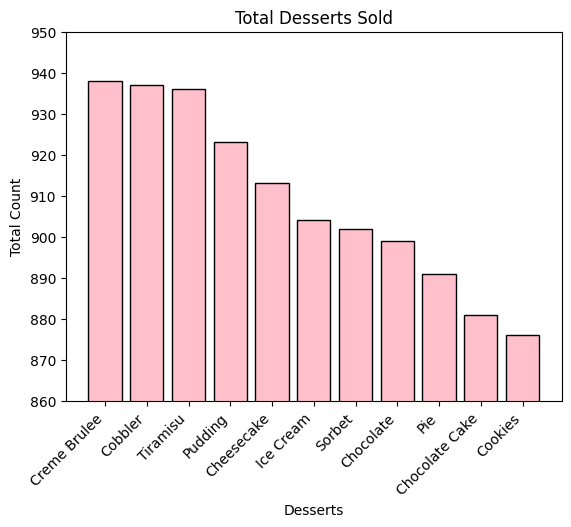

In [34]:
#Bonus - analysis () : Create an analysis report with findings and visualizations that describes and explores the data in the database.
import matplotlib.pyplot as plt

#Bar chart for most popular Desserts
desserts_count = merged_final['desserts'].value_counts()

plt.bar(desserts_count.index, desserts_count, color='pink', edgecolor='black')
plt.title('Total Desserts Sold')
plt.xlabel('Desserts')
plt.ylabel('Total Count')
plt.xticks(rotation=45, ha='right')
plt.ylim(860, 950)
plt.show()


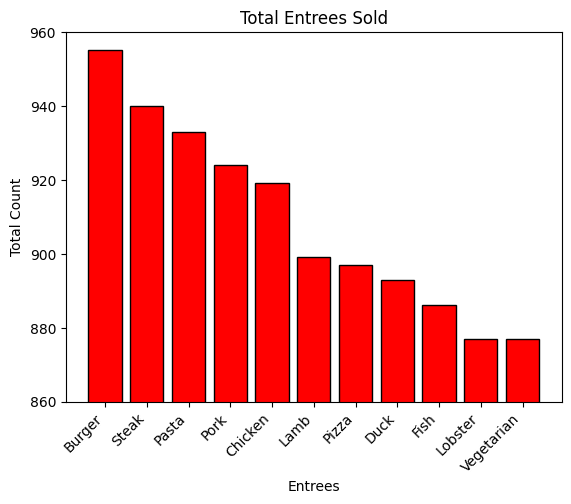

In [38]:
#Bar chart for most popular Entrees
entrees_count = merged_final['entrees'].value_counts()

plt.bar(entrees_count.index, entrees_count, color='red', edgecolor='black')
plt.title('Total Entrees Sold')
plt.xlabel('Entrees')
plt.ylabel('Total Count')
plt.xticks(rotation=45, ha='right')
plt.ylim(860, 960)
plt.show()

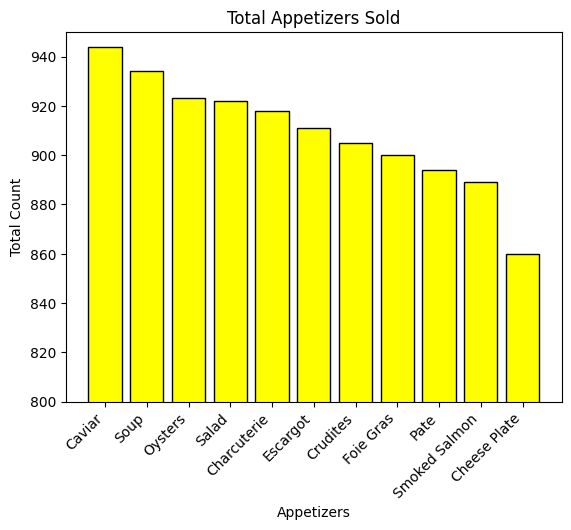

In [41]:
#Bar chart for most popular Appetizers
appetizers_count = merged_final['appetizers'].value_counts()

plt.bar(appetizers_count.index, appetizers_count, color='yellow', edgecolor='black')
plt.title('Total Appetizers Sold')
plt.xlabel('Appetizers')
plt.ylabel('Total Count')
plt.xticks(rotation=45, ha='right')
plt.ylim(800, 950)
plt.show()

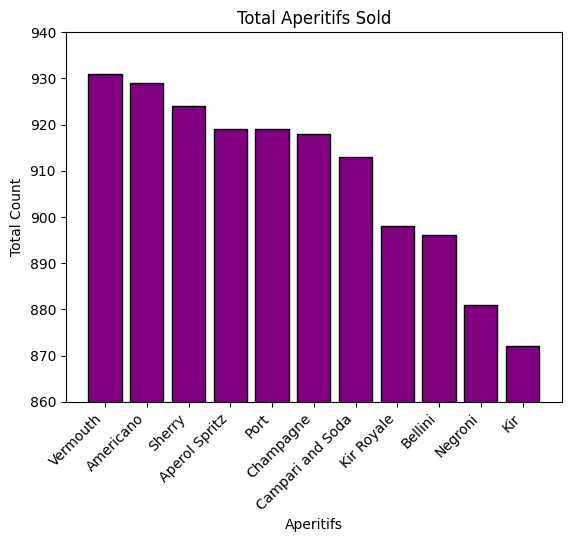

In [43]:
#Bar chart for most popular Aperitifs
aperitifs_count = merged_final['aperitifs'].value_counts()

plt.bar(aperitifs_count.index, aperitifs_count, color='purple', edgecolor='black')
plt.title('Total Aperitifs Sold')
plt.xlabel('Aperitifs')
plt.ylabel('Total Count')
plt.xticks(rotation=45, ha='right')
plt.ylim(860, 940)
plt.show()

Top 5 Most Loyal Customers:
      customer_id  total_spent
8060         1563      4508.25
3594          216      3835.53
9807          216      3835.53
3020          138      3795.68
8409         5221      3722.52


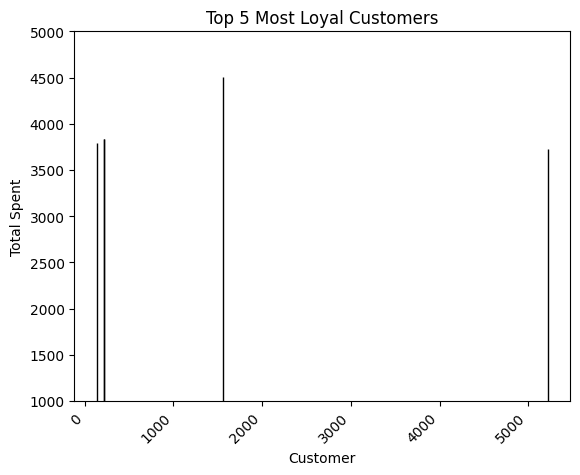

In [48]:
#Bar chart for Most Loyal Customer

sorted_df = merged_final.sort_values(by="total_spent", ascending=False)
top_5_customers = sorted_df.head(5)

print("Top 5 Most Loyal Customers:")
print(top_5_customers[['customer_id', 'total_spent']])

plt.bar(top_5_customers['customer_id'], top_5_customers['total_spent'], color='blue', edgecolor='black')
plt.title('Top 5 Most Loyal Customers')
plt.xlabel('Customer')
plt.ylabel('Total Spent')
plt.xticks(rotation=45, ha='right')
plt.ylim(1000, 5000)
plt.show()